In [7]:
from constants import x_path, y_path
import pandas as pd
from libs.simple_processing import split_train_test

X = pd.read_csv(x_path)
y = pd.read_csv(y_path)

X_train, X_valid, y_train, y_valid = split_train_test(X, y, 0.7)

X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5268,0.090909,0.1250,0.096604,0.003023,0.0,0.0,0.0,0.75,0.500000,0.085526,0.103734,0.347826,0.0,0.575758,0.865852,0.166113,0.235932,0.006581
16909,0.090909,0.3125,0.112453,0.006348,0.0,0.0,0.0,0.75,0.583333,0.100877,0.118257,0.695652,0.0,0.025253,0.645810,0.307309,0.328859,0.010395
16123,0.090909,0.1875,0.060377,0.005659,0.0,0.0,0.0,0.50,0.583333,0.087719,0.000000,0.756522,0.0,0.368687,0.755509,0.401163,0.225607,0.010581
12181,0.121212,0.3125,0.144906,0.003973,0.4,0.0,0.0,0.50,0.583333,0.210526,0.000000,0.808696,0.0,0.151515,0.425768,0.279070,0.270349,0.007293
12617,0.090909,0.3125,0.113962,0.002570,0.4,0.0,0.0,0.50,0.500000,0.104167,0.116183,0.739130,0.0,0.595960,0.788322,0.130399,0.239374,0.004723


In [5]:
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# patience below 7 cuts to early
early_stopping = EarlyStopping(
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=7,  # how many epochs to wait before stopping
    restore_best_weights=True
)

def build_regressor(hp):
    min = 60
    max = 80
    step = 4
    feat_count = X_train.shape[1]

    m = Sequential()
    m.add(Dense(units=hp.Int("units", min_value=min, max_value=max, step=step), activation="relu", input_shape=[feat_count]))
    m.add(Dense(units=hp.Int("units", min_value=min, max_value=max, step=step), activation="relu"))
    m.add(Dense(units=hp.Int("units", min_value=min, max_value=max, step=step), activation="relu"))
    m.add(Dense(units=hp.Int("units", min_value=min, max_value=max, step=step), activation="relu"))
    m.add(Dense(units=hp.Int("units", min_value=min, max_value=max, step=step), activation="relu"))
    m.add(Dense(units=hp.Int("units", min_value=min, max_value=max, step=step), activation="relu"))
    m.add(Dense(1))

    m.compile(
        optimizer="adam",
        loss="mean_absolute_error",
        metrics=[keras.metrics.MeanAbsoluteError()],
    )
    return m


# tuner = keras_tuner.RandomSearch(
tuner = keras_tuner.Hyperband(
    hypermodel=build_regressor,
    # The objective name and direction.
    # Name is the f"val_{snake_case_metric_class_name}".
    objective=keras_tuner.Objective("val_mean_absolute_error", direction="min"),
    max_epochs=50,
    factor=3,
    seed=42,
    # max_trials=2,
    overwrite=True,
    directory="keras_tuner"
)

tuner.search(
    x=X_train,
    y=y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_valid, y_valid)
)

tuner.results_summary()
# tuner.search_space_summary()
winner = tuner.get_best_models(num_models=1)
# print(winner)
winner = winner[0]
# best_model = models
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
winner.build(input_shape=[X_train.shape[1]])
winner.summary()
score = winner.evaluate(X_valid, y_valid, verbose=0)
print("Test Loss: ", score)

NameError: name 'X_train' is not defined

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten

features_count = X_train.shape[1]
units = 76
activation = 'relu'

model = Sequential()
# model.add(Dense(18, activation=relu, input_shape=[features_count]))
model.add(Dense(units, activation=activation, input_shape=[features_count]))
model.add(Dense(units, activation=activation))
model.add(Dense(units, activation=activation))
model.add(Dense(units, activation=activation))
model.add(Dense(units, activation=activation))
model.add(Dense(units, activation=activation))
# model.add(Dense(54, activation='relu'))
# model.add(Dense(54, activation='relu'))
# model.add(Dense(features_count, activation='relu'))
# model.add(Dense(features_count, activation='relu'))
model.add(Dense(1))

model.compile(
    optimizer='adam'
    # ,loss='mes'
    # , loss='mae'
    # , loss='mean_squared_error'
    , loss='mean_absolute_error'
    , metrics=[keras.metrics.MeanAbsoluteError()]
    # , metrics=[keras.metrics.MeanAbsoluteError()]
)

history = model.fit(x=X_train, y=y_train,
                    validation_data=(X_valid,y_valid)
                    , batch_size=128
                    , epochs=400
                    # , callbacks=[early_stopping]
                    , use_multiprocessing=True
                    # , verbose='2'
                    )

history_df = pd.DataFrame(history.history)
print("Minimum Validation Loss: {:0.5f}".format(history_df['val_loss'].min()))
print(history_df)

Epoch 1/400


2022-12-06 17:44:22.384014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - ETA: 0s - loss: 474228.8750 - mean_absolute_error: 474228.8750

2022-12-06 17:44:26.028134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 5s 31ms/step - loss: 474228.8750 - mean_absolute_error: 474228.8750 - val_loss: 191157.0312 - val_mean_absolute_error: 191157.0312
Epoch 2/400
119/119 [==============================] - 3s 21ms/step - loss: 181940.9531 - mean_absolute_error: 181940.9531 - val_loss: 166833.0625 - val_mean_absolute_error: 166833.0625
Epoch 3/400
119/119 [==============================] - 2s 15ms/step - loss: 165002.3125 - mean_absolute_error: 165002.3125 - val_loss: 148101.1094 - val_mean_absolute_error: 148101.1094
Epoch 4/400
119/119 [==============================] - 2s 17ms/step - loss: 143606.0938 - mean_absolute_error: 143606.0938 - val_loss: 127097.2656 - val_mean_absolute_error: 127097.2656
Epoch 5/400
119/119 [==============================] - 2s 15ms/step - loss: 129251.7422 - mean_absolute_error: 129251.7422 - val_loss: 119054.8906 - val_mean_absolute_error: 119054.8906
Epoch 6/400
119/119 [==============================] - 2s 14ms/step - loss: 123315

In [81]:
# Generate generalization metrics
from constants import output_path

score2 = model.evaluate(X_valid, y_valid, verbose=0)
print("Test Loss: ", score2)


Test Loss:  [65575.3046875, 65575.3046875]


<AxesSubplot: >

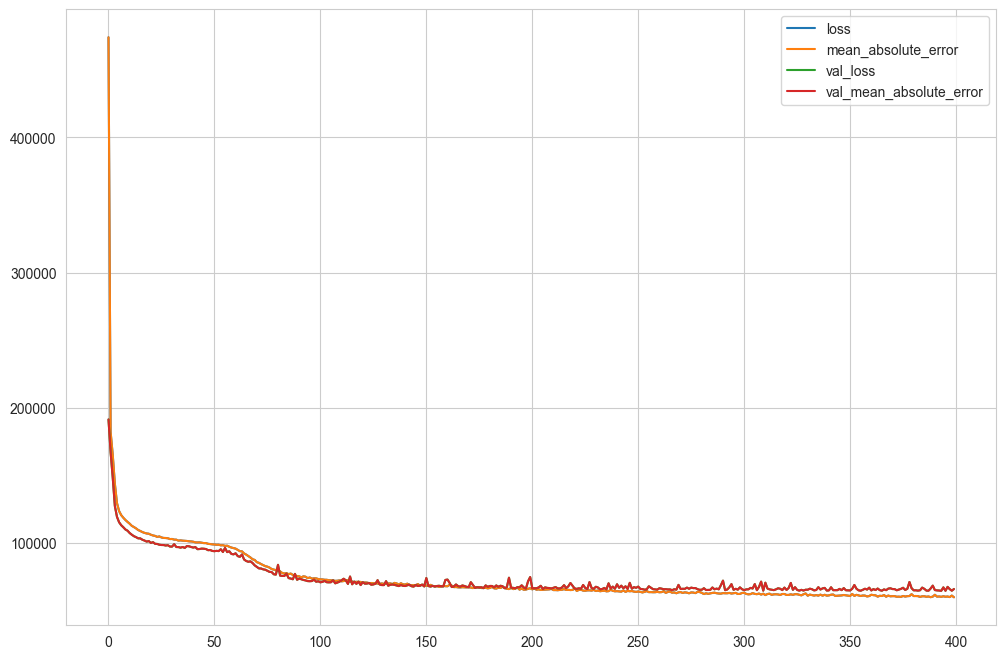

In [82]:
history_df.plot(figsize=(12,8))
